# imports

In [1]:
import pickle
from srgnn_pl import SRGNN_model, SRGNN_Map_Dataset, SRGNN_sampler
from utils import fake_parser
import torch
import os

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [224]:
import pandas as pd
import yaml
from math import ceil

# global vars

In [4]:
dfs=[]
for k in tqdm(range(33003945//int(1e6))):
    yoo_df=pd.read_table('../datasets/yoochoose-clicks.dat', sep=',', dtype=str,
                     nrows=int(1e6), skiprows=k*int(1e6), 
                     names=['session_id','timestamp','item_id','category'])
    yoo_df=yoo_df[['item_id', 'category']].drop_duplicates()
    dfs.append(yoo_df)
items_df=pd.concat(dfs).drop_duplicates()
del dfs

100%|██████████| 33/33 [02:35<00:00,  4.71s/it]


number differs as data for paper was preprocessed to use items with >=5 occurances

In [5]:
items_df=items_df.merge(pd.DataFrame(pickle.load(open('../datasets/yoochoose_itemdict_custom_augmented.txt', 'rb')), index=[0]).T.reset_index().rename(columns={'index':'item_id', 0:'item_number'}),
             on='item_id')
items_df=items_df.loc[items_df.category.isin([str(c) for c in np.arange(1,13)])]

In [6]:
with open("./wandb/run-20240107_132220-uq42516j/files/config.yaml", "r") as stream:
        config=yaml.safe_load(stream)

keys=list(config.keys())
for k in keys:
    if k not in fake_parser().__dict__.keys():
        del config[k]
    else:
        config[k]=config[k]['value']

opt=fake_parser(**config)

In [7]:
#opt.nonhybrid=True
#model=SRGNN_model.load_from_checkpoint('./models/fancy-night-28/model.ckpt', opt=opt)
model=SRGNN_model.load_from_checkpoint('./GNN_master/uq42516j/checkpoints/epoch=10-step=203478.ckpt', opt=opt)

In [6]:
#model_dir='./srgnn_model_12_3_13_40/'
#hyperparameters=pickle.load(open(model_dir+'model_hyperparameters.txt', 'rb'))
#opt=fake_parser(*list(hyperparameters.values()))

In [8]:
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))

#test_data = Data(test_data, shuffle=False)
# del all_train_seq, g
if opt.dataset == 'diginetica':
    n_node = 43098
elif opt.dataset == 'yoochoose1_64' or opt.dataset == 'yoochoose1_4':
    n_node = 37484

elif opt.dataset == 'yoochoose_custom':
    n_node = 28583
elif opt.dataset == 'yoochoose_custom_augmented':
    n_node = 27809
elif opt.dataset == 'yoochoose_custom_augmented_5050':
    n_node = 27807
else:
    n_node = 310



In [206]:
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(test_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )

data masking start
data masking 1
data masking 2
data masking 3
done masking


# test

In [17]:
print(opt.__dict__)
trainer=pl.Trainer(limit_test_batches=ceil(test_dataset.length/opt.batchSize),limit_predict_batches=ceil(test_dataset.length/opt.batchSize))
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'dataset': 'yoochoose_custom', 'batchSize': 128, 'hiddenSize': 256, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 3, 'l2': 1e-05, 'step': 3, 'patience': 10, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.2, 'pretrained_embedings': True, 'unfreeze_epoch': 1}


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_hit          │    55.567291259765625     │
│         test_loss         │     6.088133811950684     │
│         test_mrr          │    25.103282928466797     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.088133811950684,
  'test_hit': 55.567291259765625,
  'test_mrr': 25.103282928466797}]

In [8]:
print(opt.__dict__)
trainer=pl.Trainer(limit_test_batches=ceil(test_dataset.length/opt.batchSize),limit_predict_batches=ceil(test_dataset.length/opt.batchSize))
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/gpu_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read http

{'dataset': 'yoochoose_custom', 'batchSize': 128, 'hiddenSize': 256, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 3, 'l2': 1e-05, 'step': 3, 'patience': 10, 'nonhybrid': True, 'validation': True, 'valid_portion': 0.2, 'pretrained_embedings': True, 'unfreeze_epoch': 1}


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_hit          │     55.57823944091797     │
│         test_loss         │     6.196807384490967     │
│         test_mrr          │     24.7968692779541      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.196807384490967,
  'test_hit': 55.57823944091797,
  'test_mrr': 24.7968692779541}]

In [27]:
trainer=pl.Trainer(limit_test_batches=ceil(test_dataset.length/opt.batchSize),limit_predict_batches=ceil(test_dataset.length/opt.batchSize))
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_hit          │    54.454994201660156     │
│         test_loss         │     6.112325668334961     │
│         test_mrr          │    23.760805130004883     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.112325668334961,
  'test_hit': 54.454994201660156,
  'test_mrr': 23.760805130004883}]

## old code for testing

In [11]:
hit, mrr = [], []
emb_avg_hit, emb_max_hit=[],[]
emb_avg_nohit, emb_max_nohit=[],[]
session_stats=[]

slices = test_data.generate_batch(model.batch_size)
for slice_i in tqdm(slices):
   # targets, scores = forward(model, i, test_data)
    
    alias_inputs, A, items, mask, targets = test_data.get_slice(slice_i)
    alias_inputs = trans_to_cuda(torch.Tensor(alias_inputs).long())
    items = trans_to_cuda(torch.Tensor(np.asarray(items)).long())
    A = trans_to_cuda(torch.Tensor(np.array(A)).float())
    mask = trans_to_cuda(torch.Tensor(mask).long())
    hidden = model(items, A)
    zero_emb=hidden[0,0]

    get = lambda i: hidden[i][alias_inputs[i]]
    get_items=lambda i: items[i][alias_inputs[i]]

    seq_hidden = torch.stack([get(i) for i in torch.arange(len(alias_inputs)).long()])
    scores = model.compute_scores(seq_hidden, mask)
    
    
    
    sub_scores = scores.topk(20)[1]
    sub_scores = trans_to_cpu(sub_scores).detach().numpy()
    for score, target, mask, session, session_emb in zip(sub_scores, targets, test_data.mask, items, seq_hidden):
        if (sum(session!=0)>1):
            single_seq=session_emb[~(session_emb==zero_emb).all(axis=1)]
            emb_dist=torch.cdist(single_seq, single_seq, p=2)
            user_distances=torch.tensor([emb_dist[i,i+1] for i in range(emb_dist.shape[0]-1)])
            
            h=np.isin(target - 1, score)
            hit.append(h)
            session_stats.append((items_df.loc[items_df.item_number.isin(session.cpu().numpy())].category.nunique(), 
                                  sum(session!=0).cpu().numpy(),
                                  h))
            if len(np.where(score == target - 1)[0]) == 0:
                mrr.append(0)
                emb_avg_nohit.append(user_distances.mean())
                emb_max_nohit.append(user_distances.max())
            else:
                mrr.append(1 / (np.where(score == target - 1)[0][0] + 1))
                emb_avg_hit.append(user_distances.mean())
                emb_max_hit.append(user_distances.max())


hit = np.mean(hit) * 100
mrr = np.mean(mrr) * 100
hit, mrr

100%|██████████| 316/316 [02:48<00:00,  1.87it/s]


(39.39361658540583, 17.49460726735838)

# analyse results

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [126]:
import plotly.graph_objects as go
from matplotlib.pyplot import figure


# session embeddings

In [189]:
session_emb=[]
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    # use only original sessions
    a=batch[3][0]
    a=torch.vstack([torch.zeros(a.shape[1]), a])
    idxs=torch.diff(a, dim=0).sum(axis=1)
    for i in range(len(batch)):
        batch[i]=batch[i][:,idxs>0]
    #print(batch[0].shape)
    #break
    session_emb.append(model.get_session_embeddings(batch).detach().numpy())
session_emb=np.concatenate(session_emb)

1214it [01:03, 19.00it/s]                          


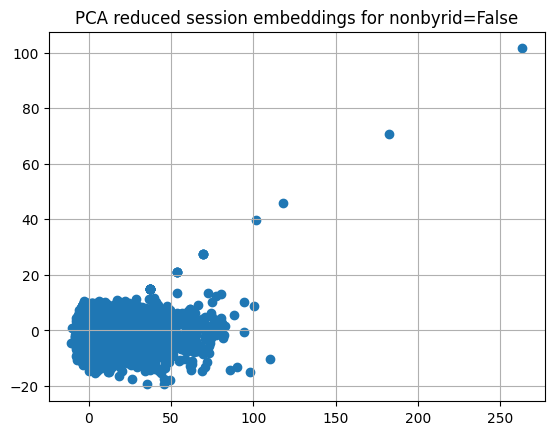

In [129]:
pca=PCA(2)
pca_session_embeddings=pca.fit_transform(session_emb)

'''fig = go.Figure()
fig.add_trace(go.Scatter(x=pca_session_embeddings[:,0], y=pca_session_embeddings[:,1], name='items', mode='markers'))

fig.update_layout(title=f'TSNE reduced session embeddings for nonbyrid={opt.nonhybrid}',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()'''
figure(figsize=(16, 12), dpi=80)

plt.scatter(x=pca_session_embeddings[:,0], y=pca_session_embeddings[:,1])
plt.title(f'PCA reduced session embeddings for nonbyrid={opt.nonhybrid}')
plt.grid()
plt.show()

In [ ]:
tsne=TSNE(2)
tsne_session_embeddings=tsne.fit_transform(session_emb)

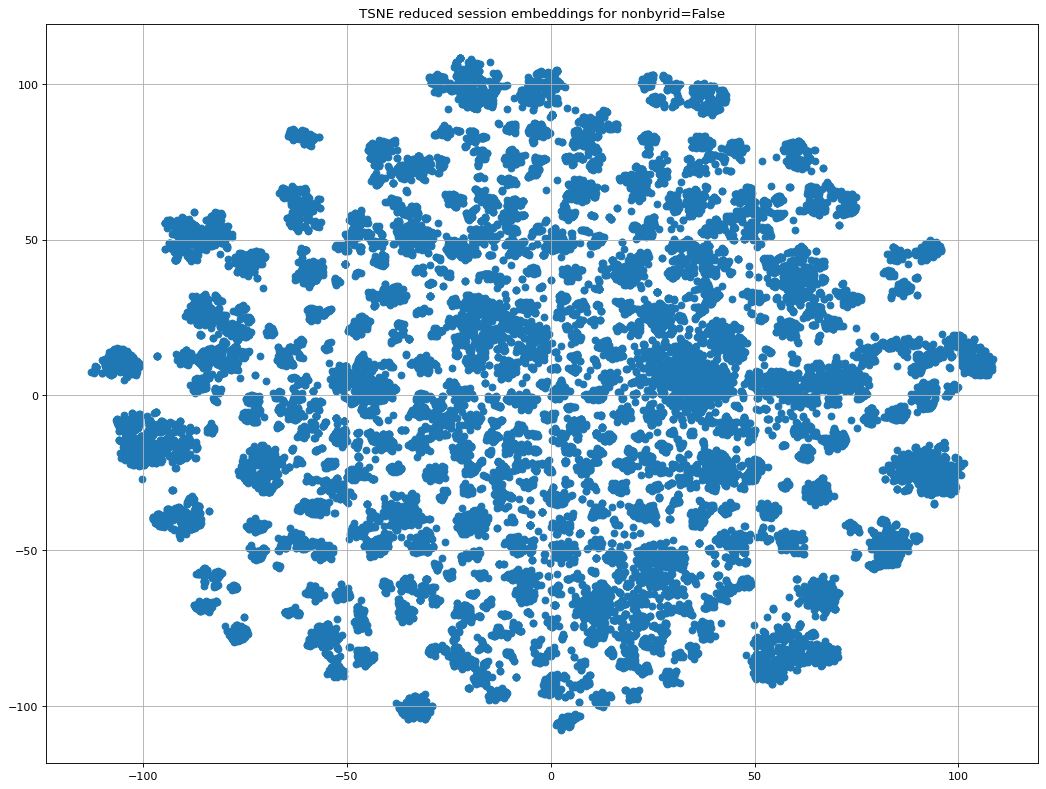

In [246]:
'''fig = go.Figure()
fig.add_trace(go.Scatter(x=pca_session_embeddings[:,0], y=pca_session_embeddings[:,1], name='items', mode='markers'))

fig.update_layout(title=f'TSNE reduced session embeddings for nonbyrid={opt.nonhybrid}',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()'''
figure(figsize=(16, 12), dpi=80)

plt.scatter(x=tsne_session_embeddings[:,0], y=tsne_session_embeddings[:,1])
plt.title(f'TSNE reduced session embeddings for nonbyrid={opt.nonhybrid}')
plt.grid()
plt.show()

In [227]:
predictions=trainer.predict(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [228]:
hit_sessions=[]
c=0
for batch, preds in tqdm(zip(test_dataloader,predictions), total=ceil(test_dataset.length/opt.batchSize)):
    # use only original sessions
    a=batch[3][0]
    a=torch.vstack([torch.zeros(a.shape[1]), a])
    idxs=torch.diff(a, dim=0).sum(axis=1)

    scores, targets=preds
    c+=sum(idxs>0)
    scores=scores[idxs>0]
    targets=targets[0][idxs>0]

    for score, target in zip(scores, targets):
        hit_sessions.append(target in score)
hit_sessions=np.asarray(hit_sessions)

1214it [00:03, 350.43it/s]                          


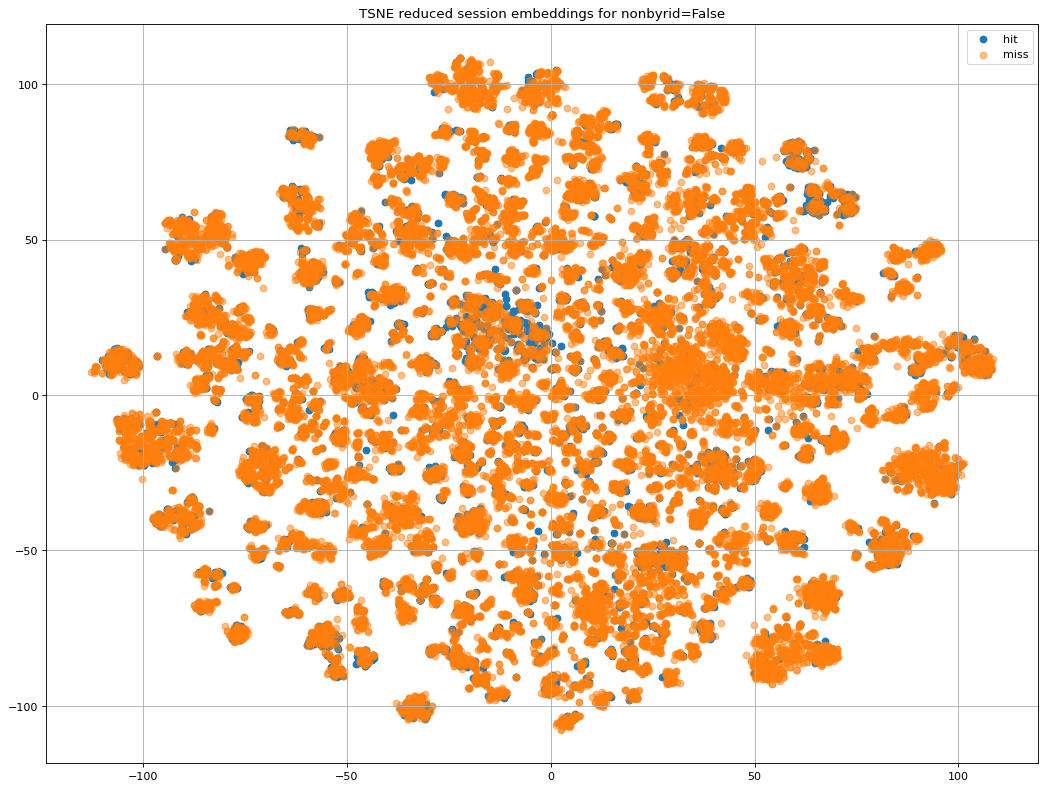

In [252]:
figure(figsize=(16, 12), dpi=80)

plt.scatter(x=tsne_session_embeddings[hit_sessions,0], y=tsne_session_embeddings[hit_sessions,1], label='hit')
plt.scatter(x=tsne_session_embeddings[~hit_sessions,0], y=tsne_session_embeddings[~hit_sessions,1], label='miss', alpha=0.5)

plt.title(f'TSNE reduced session embeddings for nonbyrid={opt.nonhybrid}')
plt.legend()
plt.grid()
plt.show()

In [239]:
categories=[]
c=0
for batch in tqdm(test_dataloader, total=ceil(test_dataset.length/opt.batchSize)):
    # use only original sessions
    a=batch[3][0]
    a=torch.vstack([torch.zeros(a.shape[1]), a])
    idxs=torch.diff(a, dim=0).sum(axis=1)

    items=batch[0][0, idxs>0].detach().numpy()

    for session_items in items:
        no_cats=items_df.loc[items_df.item_number.isin(session_items)].category.nunique()
        categories.append(no_cats)

categories=np.asarray(categories)

100%|██████████| 1214/1214 [00:14<00:00, 83.64it/s]


In [244]:
cat_plot=categories>6

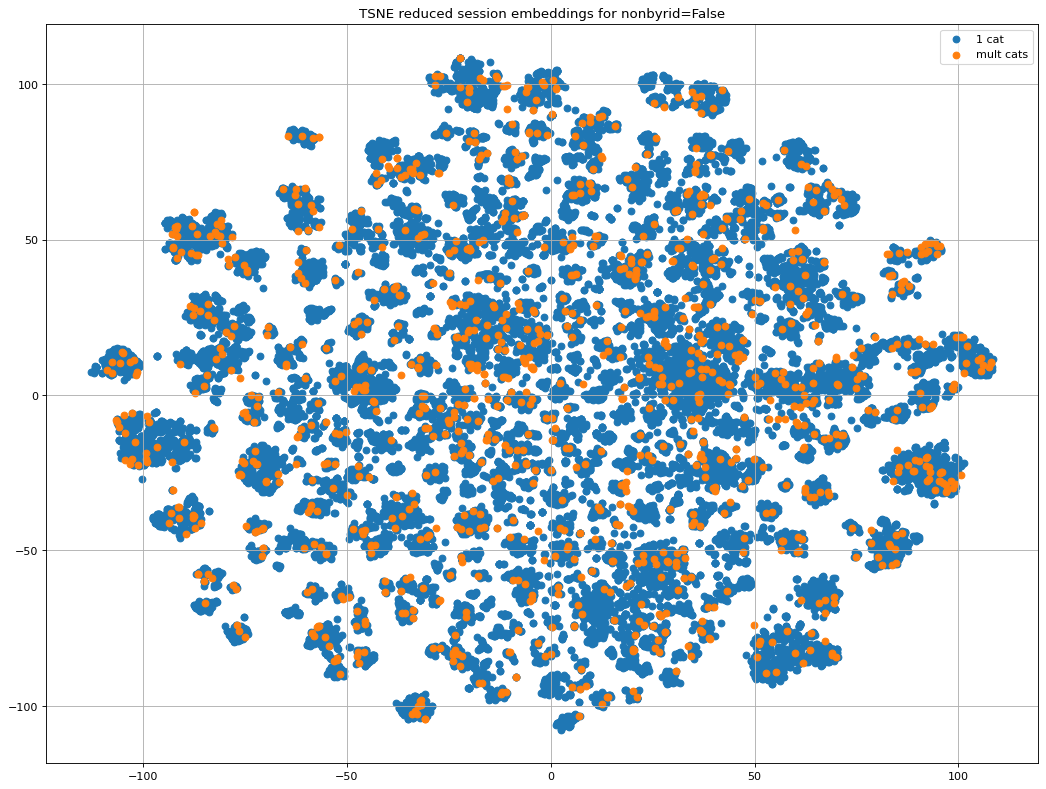

In [249]:
figure(figsize=(16, 12), dpi=80)

plt.scatter(x=tsne_session_embeddings[~cat_plot,0], y=tsne_session_embeddings[~cat_plot,1], label='1 cat')
plt.scatter(x=tsne_session_embeddings[cat_plot,0], y=tsne_session_embeddings[cat_plot,1], label='mult cats')

plt.title(f'TSNE reduced session embeddings for nonbyrid={opt.nonhybrid}')
plt.legend()
plt.grid()
plt.show()

## gausian mixture

In [257]:
from sklearn.mixture import GaussianMixture

In [258]:
gm=GaussianMixture(n_components=32, n_init=4)
    
session_labels=gm.fit_predict(session_emb)

In [261]:
fig = go.Figure()

for label in np.unique(session_labels):
    label_embedding=tsne_session_embeddings[session_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced item embeddings with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

# analyse embeddings

## input (beore gnn)

In [140]:
items_numbers_df=items_df.drop_duplicates(subset='item_number').reset_index(drop=True)#.loc[items_df.category==cat].index

In [38]:
def get_items_embedding(model, item_ids: torch.tensor):
    return model.model.embedding(item_ids)

In [148]:
pca=PCA(2)
pca_items_embeddings=pca.fit_transform(get_items_embedding(model, torch.tensor(items_df.item_number.unique())).detach().numpy())
fig = go.Figure()

for cat in items_df.category.unique():
    cat_idxs=items_numbers_df.loc[items_numbers_df.category==cat].index
    cat_embeddings=pca_items_embeddings[cat_idxs]
    fig.add_trace(go.Scatter(x=cat_embeddings[:,0], y=cat_embeddings[:,1], name=cat, mode='markers'))

fig.update_layout(title='PCA reduced item embeddings',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

In [ ]:
tsne=TSNE(2)
tsne_items_embeddings=tsne.fit_transform(get_items_embedding(model, torch.tensor(items_df.item_number.unique())).detach().numpy())

In [147]:
fig = go.Figure()

for cat in items_df.category.unique():
    cat_idxs=items_numbers_df.loc[items_numbers_df.category==cat].index
    cat_embeddings=tsne_items_embeddings[cat_idxs]
    #tsne_item_embeddings=tsne.transform(cat_embeddings)

    fig.add_trace(go.Scatter(x=cat_embeddings[:,0], y=cat_embeddings[:,1], name=cat, mode='markers'))




fig.update_layout(title='TSNE reduced item embeddings',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

## run kmeans

In [149]:
from sklearn.cluster import KMeans

In [150]:
embeddings=get_items_embedding(model, torch.arange(n_node))
embeddings.shape

torch.Size([28583, 256])

In [151]:
items_df.category.nunique()

12

In [152]:
embeddings_np=embeddings.detach().numpy()
kmeans = KMeans(n_clusters=12).fit(embeddings_np)
kmeans.cluster_centers_.shape

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(12, 256)

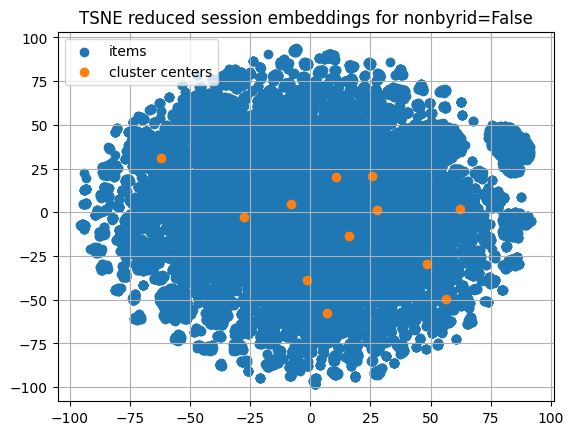

In [156]:
pca=TSNE(2)
tsne_items_embeddings=pca.fit_transform(np.vstack([kmeans.cluster_centers_, embeddings_np]))


plt.scatter(x=tsne_items_embeddings[12:,0], y=tsne_items_embeddings[12:,1], label='items')
plt.scatter(x=tsne_items_embeddings[:12,0], y=tsne_items_embeddings[:12,1], label='cluster centers')

plt.title(f'TSNE reduced session embeddings for nonbyrid={opt.nonhybrid}')
plt.legend()
plt.grid()
plt.show()

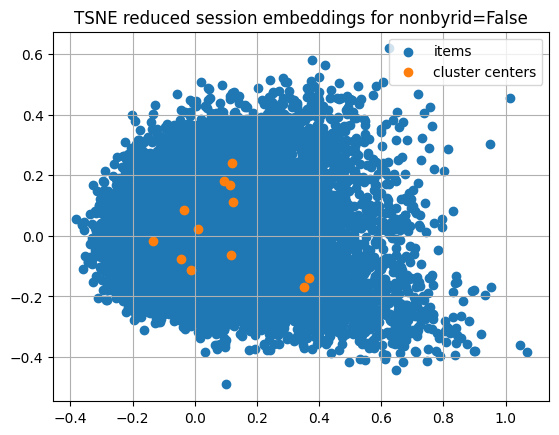

In [238]:
pca=PCA(2)

pca_item_embeddings=pca.fit_transform(embeddings_np)
pca_clusters=pca.transform(kmeans.cluster_centers_)


plt.scatter(x=pca_item_embeddings[:,0], y=pca_item_embeddings[:,1], label='items')
plt.scatter(x=pca_clusters[:,0], y=pca_clusters[:,1], label='cluster centers')

plt.title(f'TSNE reduced session embeddings for nonbyrid={opt.nonhybrid}')
plt.legend()
plt.grid()
plt.show()

## GNN embeddings

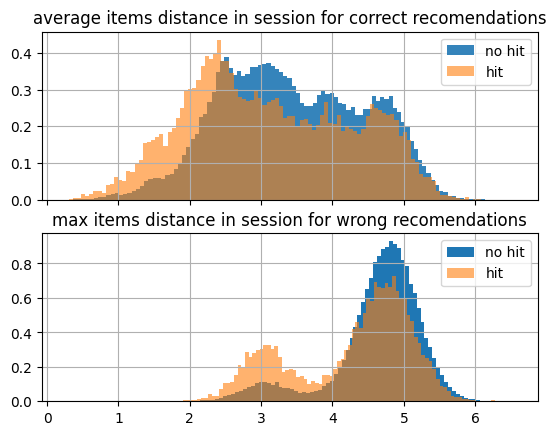

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True)



ax[0].hist(emb_avg_nohit, label='no hit', alpha=0.9, cumulative=False, density=True, bins=100)
ax[0].hist(emb_avg_hit, label='hit', alpha=0.6, cumulative=False, density=True, bins=100)
ax[0].set_title('average items distance in session for correct recomendations')
ax[0].grid()
ax[0].legend()

ax[1].hist(emb_max_nohit, label='no hit', cumulative=False, density=True, bins=100)
ax[1].hist(emb_max_hit, label='hit', cumulative=False, density=True, bins=100, alpha=0.6)
ax[1].set_title('max items distance in session for wrong recomendations')
ax[1].grid()
ax[1].legend()

plt.show()

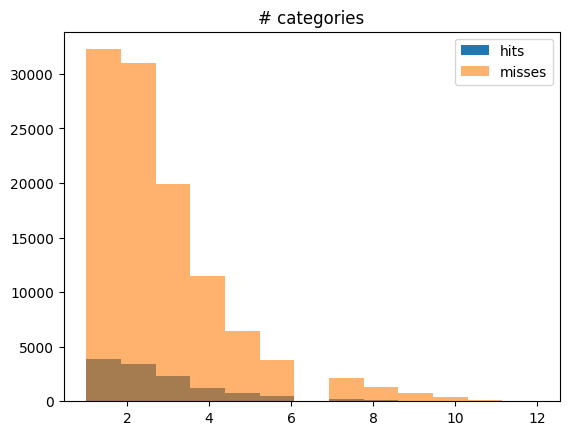

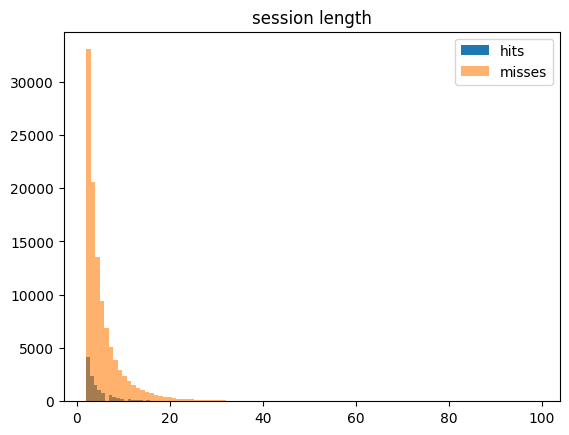

In [29]:
session_stats=np.asarray(session_stats)
hits=session_stats[:,2]==1
plt.hist(session_stats[hits, 0], label='hits', bins=13)
plt.hist(session_stats[~hits, 0], label='misses', alpha=0.6, bins=13)
plt.title('# categories')
plt.legend()
plt.show()

plt.hist(session_stats[hits, 1], label='hits', bins=100)
plt.hist(session_stats[~hits, 1], label='misses', alpha=0.6, bins=100)
plt.title('session length')
plt.legend()
plt.show()